In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
name = 'LNemec'
dataset_size = 100000

---
# New York City Taxi Ride Prediction
---

In this workshop, wee will explore the New York City taxi trip records. The New York City Taxi and Limousine Commission (TLC) provides the data is open datasets. It was collected by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The TLC makes no warranties about the accuracy of this data.

We will use the NYC taxi trip data from 2015 to predict the duration of a Taxi trip for a taxi ride in New York City given the pickup and dropoff locations and date & time. At your next visit to New York such that you at your next visit to New York can make an informed descion between public transport (e.g. provided by the [NYC Transit App](https://apps.apple.com/us/app/transit-bus-subway-times/id498151501) )

<img src='https://media.giphy.com/media/2ZXsHDuIhvu2yxMgFI/giphy.gif' align='center'/>

The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

***
## Loading and setting up our python environment
***

As a first step we load the python modules, that we will use in this tutorial.

In [3]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

cwd = os.getcwd()
root = os.path.abspath(os.path.join(os.getcwd(),".."))

Python modules for data visualisation. In addition, we set the layout for data visualisation to seaborn poster style. Just to make everything pretty.

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('seaborn-whitegrid')
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=1.2)
current_palette = sns.color_palette()

Microsoft Azure specific python modules and setup.

In [5]:
from azureml.core import Workspace, Experiment

exp_name = "New-York-City_Taxi_" + name
ws = Workspace.from_config()
experiment = Experiment(workspace=ws, name=exp_name)

## The Data Science development cycle
***

The development of machine learning solutions is highly iterative. The development cycle starts with getting the right data. In real applications this is the field where Internet of Things (IoT) technologies and Data Science/ Machine Learning enrich each other. For example, the TLC had to implement and roleout a solution that collects the information of every taxi ride in New York City. This solution had to be implemented in such a way that it is accepted by the drivers on the one hand side and scalable to at best all taxis registered with the TLC.
Happily, this problem was solved and the resulting data is provided by the TLC open for use.

<img src='../img/DataScienceDevCycle_1.png' align='center' width="500"/>

The data can be downloaded from the [TLC Trip Record Data webpage](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

For the purpose of this tutorial, we already downloaded the data for you for further processing. Into the directory NYC_yellow_cap.

In [6]:
datapath=os.path.join(root, "NYC_yellow_cap")
datafiles = [os.path.join(datapath, f) for f in os.listdir(datapath) if f[-7:] == 'csv.zip']

We have data from the year 2015. The taxi trip records are stored in comma separated values (csv) files with one file per month. 

In [7]:
%%time
df_list = [pd.read_csv(f, sep=',', engine='c') for f in datafiles]
data = pd.concat(df_list, ignore_index=True)
data = data.iloc[:,1:]

CPU times: user 1min 7s, sys: 3.24 s, total: 1min 10s
Wall time: 1min 14s


# Explore the data
***

<img src='../img/DataScienceDevCycle_2.png' align='center' width="500"/>

Before we explore the data in detail. We will have a look on the data records and what each column represents. An official description of the included record fields if given in the [pdf](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) on their webpage.

In [8]:
data.shape

(18264128, 10)

There are approx 18 million records in our dataset. However, the original dataset provided by the TLC for the year 2015 is 8 times bigger containing almost 150 million records.

### Feature details:

* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* tip_amount - This field is automatically populated for credit card tips. Cash tips are not included
* total_amount - The total amount charged to passengers. Does not include cash tips (including tips, taxs, fares, surcharge)
           
### Label details:
* trip_duration - duration of the trip in seconds

### Computed details:
* distance - was calculated in advance from the pick-up and drop-off coordinates using [Haversine formula](
https://en.wikipedia.org/wiki/Haversine_formula)

In [9]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,distance
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,-73.993896,40.750111,-73.974785,40.750618,17.05,1083.0,1.610896
1,2015-01-10 20:33:39,2015-01-10 21:11:35,3,-73.783043,40.644356,-73.987595,40.759357,58.13,2276.0,21.467589
2,2015-01-15 19:05:40,2015-01-15 19:21:00,5,-73.968704,40.754246,-73.955124,40.786858,14.30,920.0,3.802335
3,2015-01-15 19:05:41,2015-01-15 19:22:11,5,-73.997459,40.736362,-73.978172,40.761856,15.80,990.0,3.267355
4,2015-01-15 19:05:43,2015-01-15 19:17:43,2,-73.985092,40.756989,-73.984879,40.780151,14.00,720.0,2.575657


## 1. Taxi passenger count

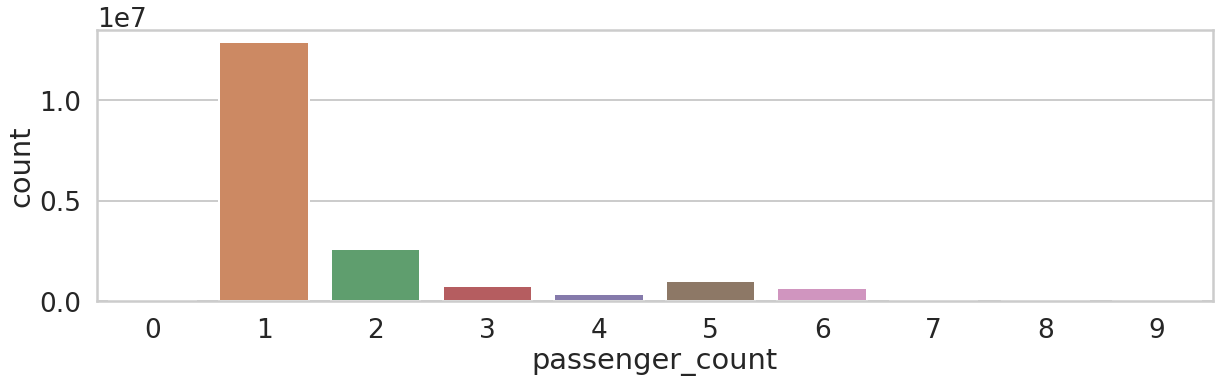

In [10]:
plt.figure(figsize = (20,5))
sns.countplot(data.passenger_count)
plt.show()

### Observations:
Most of trip consist of passenger either 1 or 2.
There are some trips with 0 passenger count.
Few trips consisted of even 7, 8 or 9 passengers.

#### Trips with 0 passenger:
Passenger count is a driver entered value. Since the trip is not possible without passengers. It is evident that the driver forgot to enter the value for the trips with 0 passenger count. Lets analyze the passenger count distribution further to make it consistent for further analysis.

In [11]:
mean = data.passenger_count.mean()
median = data.passenger_count.median()

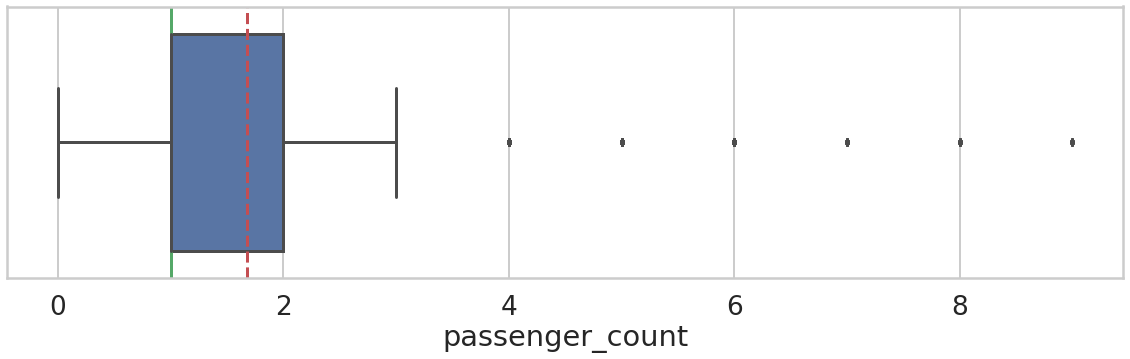

In [12]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1, 1, 1)

sns.boxplot(data.passenger_count, ax=ax)
ax.axvline(mean, color='r', linestyle='--')
ax.axvline(median, color='g', linestyle='-')
plt.show()

### Idea:
As we see in the boxplot, the mean (red line) and median (green line) values are approx equal to 1. We therefore replace the 0 passenger count with 1.

In [13]:
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

### Idea:
#### Trips with 7, 8 or 9 passenger:

The New York City Taxi Passenger Limit says:
* A maximum of 4 passengers can ride in traditional cabs
* There 5 passenger cabs (minivans).
* One child under 7 is allowed to sit on a passenger's lap in the rear seat in addition to the passenger limit.

We can conclude, that in total a maximum of 6 passenger can board a new york taxi i.e. 5 adult + 1 child. Thus, we remove the records with passenger count > 7, 8 or 9 because they suspicious extreme values and may hint to inconsitent data.

In [14]:
data = data[data.passenger_count <= 6]

Now the data is consistent with respect to the passenger count.

In [15]:
%%bash
cd ..
mkdir data_preprocessed

mkdir: cannot create directory ‘data_preprocessed’: File exists


CalledProcessError: Command 'b'cd ..\nmkdir data_preprocessed\n'' returned non-zero exit status 1.

In [ ]:
# In case of any unforseen issues load data and continue from here
datapath=os.path.join(root, "data_preprocessed")
data.to_parquet(os.path.join(datapath,'preprocessing_1-data.parquet'))
# data = pd.read_parquet('data_preprocessed/preprocessing_1-data.parquet')

## 2. Pickup and dropoff time

First, we convert the pickup and dropoff time to a python pandas specific datetime format. With the datetime format, we can add details like hour, weekday or monthas.
In the following, we calculate and assign new columns to the dataframe such as weekday,
month and pickup_hour which will help us to gain more insights from the data.

In [ ]:
#Check the type of each variable
data.dtypes.reset_index()

In [ ]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

Add additional columns with time information

In [ ]:
data['month'] = data.pickup_datetime.dt.month
data['weekday'] = data.pickup_datetime.dt.weekday_name
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [ ]:
plt.figure(figsize = (20,5))
sns.countplot(data.month)
plt.show()

In [ ]:
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize = (20,5))
sns.countplot(data.weekday, order = weekdays)
plt.show()

In [ ]:
plt.figure(figsize = (20,5))
sns.countplot(data.pickup_hour)
plt.show()

In [ ]:
# %%time
# n = sns.FacetGrid(data, row='weekday', row_order = weekdays, aspect=4)
# n.map(sns.countplot, 'pickup_hour', palette = current_palette)
# plt.show()
# plt.savefig('./img/weekday-pickuphour-grid.png')

Generating the plot takes about 5 minutes, so we will incude it as an image.
<img src='../img/weekday-pickuphour-grid.png' align='center' width="800"/>

###  Observations

 * Taxi pickups seem to be consistent across the week at 3 pm.
 * Taxi pickups at 7 am from Monday to Friday, but strongly reduced on weekends
 * Taxi pickups increased in the late night hours over the weekend

In [ ]:
bins = np.arange(0,25,3)
labels = [ "(%s - %s]"%(bins[i-1], bins[i]) for i in range(1, bins.shape[0]) ]
data['Time_Window'] = pd.cut(data['pickup_hour'], bins=bins, labels=labels, right=False)

In [ ]:
plt.figure(figsize = (20,5))
sns.countplot(data.Time_Window)
plt.show()

In [ ]:
# In case of any unforseen issues load data and continue from here
datapath=os.path.join(root, "data_preprocessed")
data.to_parquet(os.path.join(datapath,'preprocessing_2-data.parquet'))
# data = pd.read_parquet('data_preprocessed/preprocessing_2-data.parquet')

## 3. Rule by New York City Taxi and Limousine Commission (TLC) agency

The data trip duration is the observable, we like to predict. Therefore, it is very important that we train our machine learning algorithm based on correct data trip duration in our training dataset.

The rule below applies to all TLC-licensed drivers. No company is permitted to dispatch trips to drivers who have exceeded 10 hours of passenger time in any 24-hour period.

Passenger time is when a rider is in your car. It does not include time spent waiting for trip requests, driving to pick up riders, or waiting for riders to get to your car. The 10 hours (36000s) limit can be reset and the driver can get back on the road after 8 hours offline.

We assume an additional 2 hour time buffer because cap driver may break the 10 hour limit. In total, we assume a maximum um 12 hour (43200 s)

In [ ]:
data = data[data.trip_duration <= 43200]
data = data[data.trip_duration >= 60]

In [ ]:
mean = data.trip_duration.mean()
median = data.trip_duration.median()

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1, 1, 1)

sns.boxplot(data.trip_duration, ax=ax)
ax.axvline(mean, color='r', linestyle='--')
ax.axvline(median, color='g', linestyle='-')
plt.show()

In [ ]:
data['trip_duration_min'] = (data.trip_duration/60.0)

plt.figure(figsize = (20,5))
data.trip_duration_min.groupby(pd.cut(data.trip_duration_min, np.arange(0,120,10))).count().plot(kind='bar')

plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Trip Counts')

plt.show()

In [ ]:
# In case of any unforseen issues load data and continue from here
datapath=os.path.join(root, "data_preprocessed")
data.to_parquet(os.path.join(datapath,'preprocessing_3-data.parquet'))
# data = pd.read_parquet('data_preprocessed/preprocessing_3-data.parquet')

## 4. Pickup and drop off coordinates

We set the limits of the longitudal and latitudal coordinates of New York sufficiently to allow for trips from and to the neighbouring states.

In [ ]:
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

In [ ]:
data = data[data['pickup_latitude'].between(lat_min, lat_max)]
data = data[data['dropoff_latitude'].between(lat_min, lat_max)]

data = data[data['pickup_longitude'].between(lon_min, lon_max)]
data = data[data['dropoff_longitude'].between(lon_min, lon_max)]

In [ ]:
%%time
fig = plt.figure(figsize = (20,5))
ax_lati = fig.add_subplot(1, 2, 1)
ax_long = fig.add_subplot(1, 2, 2)

sns.boxplot(x="variable", y="value", data=pd.melt(data[['pickup_latitude', 'dropoff_latitude']]), ax = ax_lati)
sns.boxplot(x="variable", y="value", data=pd.melt(data[['pickup_longitude', 'dropoff_longitude']]), ax = ax_long)

plt.show()

In [ ]:
# %%time

# current_palette = sns.color_palette()
# fig = plt.figure(figsize = (20,20))
# ax = fig.add_subplot(1, 1, 1)
# df = data.sample(n=7200000)

# pick_long= df.loc[:,'pickup_longitude'].values
# pick_lat = df.loc[:,'pickup_latitude'].values

# drop_long= df.loc[:,'dropoff_longitude'].values
# drop_lat = df.loc[:,'dropoff_latitude'].values

# ax.scatter(x=pick_long, y=pick_lat, c=np.array([current_palette[2]]), alpha=0.6, s=3, label='pick up coordinate')
# ax.scatter(x=drop_long, y=drop_lat, c=np.array([current_palette[0]]), alpha=0.6, s=3, label='drop off coordinate')

# ax.legend()
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.savefig('./img/scatter_location.png')
# plt.show()

Generating the plot takes about 10 minutes, so we will incude it as an image.
<img src='../img/scatter_location.png' align='center' width="1200"/>

In [ ]:
# In case of any unforseen issues load data and continue from here
datapath=os.path.join(root, "data_preprocessed")
data.to_parquet(os.path.join(datapath,'preprocessing_4-data.parquet'))
# data = pd.read_parquet('data_preprocessed/preprocessing_4-data.parquet')

## 4. Distance and speed

From the starting and destination, we make a rough estimation the distance and speed.

### Estimating the distance

We calculated the distance (calc_distance) between the pickup and the dropoff coordinates using [Haversine formula](
https://en.wikipedia.org/wiki/Haversine_formula). We did it in advance for you to save us time.

In [ ]:
def calc_distance(df):
    from haversine import haversine
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

Calculate an estimation of the distance and assign new column to the dataframe.
We have done it for you and provided the column in the data set, however if you would like to work on the full TLC data set, you have the code snipplet to do it yourself.

In [ ]:
# data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

### Estimating the driving speed

Speed is a function of distance and time. In our training data set we can calculate an estimation of the speed in km/h. This is a data cleaning step, because to calculate the driving speed we need the trip duration and trip duration is the unknown variable we will predict with our machine learning algorithm.

In New York the maximum speed limit is 25 mph in urban area (approx. 40 km/h) and 65 mph on controlled state highways (approx 104 km/h). We assume that the average speed of a trip is below the maximum speed limit of 104 km/h 

In [ ]:
data['speed'] = (data.distance/(data.trip_duration/3600.0))
data = data[data.speed <= 104]

In [ ]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1, 1, 1)

data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh', ax=ax)
ax.set_xlabel('Trip count')
ax.set_ylabel('estimated Speed (km/h)')

plt.show()

We have carefully cleaned the data, before we proceed we store the data to a [parquet](https://parquet.apache.org/) file.

In [ ]:
# In case of any unforseen issues load data and continue from here

datapath=os.path.join(root, "data_preprocessed")
data.to_parquet(os.path.join(datapath,'cleaned_data.parquet'))
# data = pd.read_parquet(os.path.join(datapath,'cleaned_data.parquet'))

## Feature Engineering
***

After looking at the dataset from different perspectives. Let's prepare our dataset before training our model. Since our dataset do not contain very large number of dimensions. We will use the Principal Component Analysis (PCA) feature extraction technique.

<img src='../img/DataScienceDevCycle_3.png' align='center' width="500"/>

Let's assign the values to X & y array from the dataset.

In [ ]:
y = data.loc[:,'trip_duration'].values

In [ ]:
data_train = data.drop(['pickup_datetime',
                        'dropoff_datetime',
                        'total_amount',
                        'trip_duration',
                        'distance',
                        'weekday_num',
                        'trip_duration_min',
                        'pickup_hour',
                        'speed'], axis=1)

In [ ]:
data = 0
#First check the index of the features and label
list(zip( range(0,len(data_train.columns)),data_train.columns))

In [ ]:
data_train.head()

### Transforming categorical data

Transform categorical data into a Boolean variable or in other words we dummify all the categorical features.

Categorical data refers to data that represent categories - data with a fixed and unordered number of values. For example in the New York taxi data set, the columns vendor_id or month are categorical. Categorical data is a challenge for developing machine learning models.  Working with categorical data requires a transformation from a categorical to a numerical representation. A typical method is the introduction of so-called dummy variables. Dummy variables represent the presence or absence of categorical values by values 1 or 0. 

However, you have to ensure that the originally independent variables do not accidentally become multicollinear. In other words, you want to avoid the scenario where two or more variables are highly correlated; in simple terms, one variable can be predicted by the others. This is also known as the dummy-trap.

In [ ]:
cat_col = [("month","month"), 
           ("weekday", "weekday"),
           ("passenger_count", "passenger"),
           ("Time_Window", "TW")]

for feature, col_prefix in cat_col:

    dummy = pd.get_dummies(data_train.loc[:,feature], prefix=col_prefix)
    # Removing the first column avoids the dummy-trap
    dummy.drop(dummy.columns[0], axis=1, inplace=True)
    data_train = pd.concat([data_train,dummy], axis = 1)

In [ ]:
data_train = data_train.drop(['month',
                        "weekday",
                        "passenger_count",
                        "Time_Window"], axis=1)
data_train.head()

In [ ]:
X = data_train.iloc[:,:].values

In [ ]:
#First check the index of the features and label
list(zip( range(0,len(data_train.columns)),data_train.columns))

In [ ]:
data_train = 0

### Split Data
Before training our model on the dataset, we need to split the dataset into training and testing datasets. This is required to train our model on the major part of our dataset and test the accuracy of the model on the minor part. Let's split it

In [ ]:
#Split raw data
X, X_test, y, y_test = train_test_split(X,y, random_state=191012, test_size=0.2)

## Feature Extraction
***
We will use PCA for feature extraction i.e. Principal Component Analysis. It is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

### Scale Data
It is suggested to scale the input varibles first before applying PCA to standardise the variance and avoid the bias. Lets Scale the data using StandardScaler. The effect and importance of scaling your data is nicely demonstrated by the [scikit-learn comunity](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [ ]:
# plt.figure(figsize=(16,16))
# corr = pd.DataFrame(X[:,:]).corr()
# corr.index = pd.DataFrame(X[:,:]).columns
# sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
# plt.title("Correlation Heatmap", fontsize=16)
# plt.savefig('./img/correlation_matrix.png')
# plt.show()

A correlation matrix shows the correlation coefficients between two variables. Each cell represents the correlation between two variables. A correlation matrix is used as a way to summarize data, to identified correlated variables.

<img src='../img/correlation_matrix.png' align='center' width="1400"/>

### PCA application

Let's apply PCA technique on the training features to understand how many principal components should we select for our model to capture atleast 90% variance. For that we will take help of plot and cumsum function of numpy package.

A visual explenation of the [Principal Component Analysis](http://setosa.io/ev/principal-component-analysis/) was published by [Victor Powell](https://twitter.com/vicapow) and [Lewis Lehe](http://lewislehe.com/).

In [ ]:
run =  experiment.start_logging()
pca = PCA().fit(X)

In [ ]:
run.complete()

PCA is applied on the training and the test dataset. Our input features are now ready for the regression.

In [ ]:
run.log("Method", "PCA")
run.log("explained_variance_ratio", pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
pca_32 = PCA(n_components=32)
run.log("n_components", 32)
X_train_pca = pca_32.fit_transform(X)
X_test_pca = pca_32.transform(X_test)
run.complete()

In [ ]:
# plt.figure(figsize=(16,16))
# corr = pd.DataFrame(X_train_pca).corr()
# corr.index = pd.DataFrame(X_train_pca).columns
# sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
# plt.title("Correlation Heatmap after PCA", fontsize=16)
# plt.savefig('./img/correlation_matrix_pca.png')
# plt.show()

### Observations
All of the features shows **NO** correlation at all. Because feature extraction removes all collinearity.
 
<img src='../img/correlation_matrix_pca.png' align='center' width="1400"/>

Let's move on to the Model now.

## Model
***
Our machine learning shall output the duration of a taxi in New York City given the pickup time and location, tha dropoff location and number of pasengers. Since our dependent variable is the trip duration. It is a continous value so we will use regression technique to predict our output. Our independent variables are the passenger count, pickup longitude and latitude, the dropoff longitude and latitude, the month, weekday and a two hour time window.

### Multiple Linear Regression

It is used to explain the relationship between one continuous dependent variable and two or more independent variables. Linear Regression is most likely the simplest machine learning algorithm. A detailed explanation can be found in the [Blog article](https://towardsdatascience.com/linear-regression-understanding-the-theory-7e53ac2831b5) by [Marco Peixeiro](https://towardsdatascience.com/@marcopeixeiro) Linear regression assumes a linear relation between the input variable (independent variables) and the predicted outcome (dependent variable). Linear regression models are often fitted using the least squares approach, but they may also be fitted in other ways, such as by minimizing a penalized version of the least squares cost function as in ridge regression (L2-norm penalty) and lasso (L1-norm penalty). By construction the linear regression is not sensitive towards scaling the independent input variables. Let's proceed

### Model training

We first will use the transformed (PCA) and scaled input data. Training a linear regrission model is quite fast even on very large datasets. So considering the size of our dataset this seems to be the correct approach as of now. Let's see how it performs.


<img src='../img/DataScienceDevCycle_4.png' align='center' width="500"/>

### Train Machine Learning Model: Linear Regression with scaling & PCA

In [ ]:
run =  experiment.start_logging()
run.log("Method", "Linear Regression with PCA")
run.log("Dataset Size", X_train_pca.shape[0])

In [ ]:
%%time
#Linear regressor for the Feature extraction group with pca
regressor = LinearRegression() 
regressor.fit(X_train_pca,y) 

## Evaluate the machine learning model
***

Our model predicits a continues variable, namely the NYC taxi trip duration. To estimate the accuracy of our machine learning model, we will use one of the most popular evaluation metric used in regression problems -- Root Mean Squared Error (RMSE). The assumption behind the RMSE is that error are unbiased and follow a normal distribution. The reliability off the RMSE as a evaluation metric depends strongly on the fullfilment of this asssumptions.

$$ RMSE = \sqrt{ \frac{1}{N} \sum_{i}^{N} (\text{predicted}_i - \text{actual}_i)^2 }$$

Here, $N$ is the total number of entries in our test dataset (total number of observations). For every entry $i$ the difference between the predicted value, in our case the duration of a taxi trip, and the actual value is calculated. The RMSE is particularly robust due to its ‘squared’ nature which prevents cancelling the positive and negative error values.
When we have more samples, reconstructing the error distribution using RMSE is considered to be more reliable.
RMSE is highly affected by outlier values. Hence, make sure you’ve removed outliers from your data set prior to using this metric.
As compared to mean absolute error, RMSE gives higher weightage and punishes large errors.

<img src='../img/DataScienceDevCycle_5.png' align='center' width="500"/>

### Evaluate Machine Learning Model: Linear Regression with scaling & PCA

We can write down the linear regression formula:
$$ y_i = \beta_{0} + \beta_1 \cdot x_{i1} + \beta_2 \cdot x_{i2} + \beta_3 \cdot x_{i3} + ... + \beta_{31} \cdot x_{i32} + \varepsilon = \beta_0 + \sum_j^{p=32} \beta_j \cdot x_{ij}  $$

The parameter $\beta$ have been determined by our machine learning training using a [least squares fitting](http://mathworld.wolfram.com/LeastSquaresFitting.html) algorithm.
We can output the parameter $\beta_{0}$ which represents the y-axis intersection and the 32 $\beta_{1...32}$ parameters.

In [ ]:
# print the coefficients
print(regressor.intercept_)
print(regressor.coef_)

In [ ]:
%%time
#Predict from the test features of Feature Extraction group
y_pred = regressor.predict(X_test_pca)

In [ ]:
#Evaluate the regressor on the Feature extraction group
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
sigma =regressor.score(X_test_pca, y_test)
run.log("RMSE", RMSE)
run.log("variance", sigma)
run.complete()

In [ ]:
print('RMSE score for the Multiple LR PCA is : {0:.2f} seconds'.format(RMSE))
print('Variance score for the Multiple LR PCA is : %.2f' % sigma)

The variance score in the context of a linear regression, measure of how far observed values differ from the average of predicted values, i.e., their difference from the predicted value mean. The goal is to have a value that is low.

### Train Machine Learning Model: Random Forest Regression with scaling & PCA

A [random forest](https://en.wikipedia.org/wiki/Random_forest) regressor is a collection or smartly combined collection of [decision trees](https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d) (see the blog article by [Frank Ceballos](https://towardsdatascience.com/@frank.ceballos)). One can see a random forest as a meta estimator that fits a number of decision trees on various sub-samples of the dataset and uses for example averaging to improve the predictive accuracy.

<img src='../img/DataScienceDevCycle_4.png' align='left' width="200"/>

In [ ]:
idx = np.random.randint(X_train_pca.shape[0], size=dataset_size)

In [ ]:
run =  experiment.start_logging()
run.log("Method", "RandomForestRegressor")
run.log("Dataset Size", dataset_size)

In [ ]:
%%time
#instantiate the object for the Random Forest Regressor with scaling & PCA
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(X_train_pca[idx,:],y[idx])

### Evaluate Machine Learning Model: Random Forest Regression with scaling & PCA

<img src='../img/DataScienceDevCycle_5.png' align='left' width="200"/>

In [ ]:
for k in regressor.get_params():
    run.log(k, regressor.get_params()[k])

In [ ]:
%%time
#Predict the output with object of PCA params for Feature Extraction Group
y_pred = regressor.predict(X_test_pca)

In [ ]:
#Evaluate the regressor on the Feature extraction group
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
sigma =regressor.score(X_test_pca, y_test)
run.log("RMSE", RMSE)
run.log("variance", sigma)
run.complete()

In [ ]:
print('RMSE score for the Multiple LR PCA is : {0:.2f} seconds'.format(RMSE))
print('Variance score for the Multiple LR PCA is : %.2f' % sigma)

### Train Machine Learning Model: Random Forest Regression without scaling & PCA

<img src='../img/DataScienceDevCycle_4.png' align='left' width="200"/>

In [ ]:
run =  experiment.start_logging()
run.log("Method", "RandomForestRegressor without scaling & PCA")
run.log("Dataset Size", dataset_size)

In [ ]:
%%time
#instantiate the object for the Random Forest Regressor
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(X[idx,:],y[idx])

In [ ]:
for k in regressor.get_params():
    run.log(k, regressor.get_params()[k])

### Evaluate Machine Learning Model: Random Forest Regression without scaling & PCA

<img src='../img/DataScienceDevCycle_5.png' align='left' width="200"/>

In [ ]:
%%time
#Predict the output with object of default params for Feature Selection Group
y_pred = regressor.predict(X_test)

In [ ]:
#Evaluate the regressor on the Feature extraction group
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
sigma = regressor.score(X_test, y_test)
run.log("RMSE", RMSE)
run.log("variance", sigma)
run.complete()

In [ ]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {0:.2f} seconds'.format(RMSE))
print('Variance score for the Multiple LR raw is : %.2f' %sigma)

### Train Machine Learning Model: Random Forest Regression with scaling & PCA

<img src='../img/DataScienceDevCycle_4.png' align='left' width="200"/>

In [ ]:
run =  experiment.start_logging()
run.log("Method", "RandomForestRegressor")
run.log("Dataset Size", dataset_size)

In [ ]:
%%time
regressor = RandomForestRegressor(n_estimators = 26,
                                  max_depth = 24,
                                  min_samples_split = 9,
                                  n_jobs=-1)
regressor.fit(X_train_pca[idx,:],y[idx])

In [ ]:
for k in regressor.get_params():
    run.log(k, regressor.get_params()[k])

### Evaluate Machine Learning Model: Random Forest Regression with scaling & PCA

<img src='../img/DataScienceDevCycle_5.png' align='left' width="200"/>

In [ ]:
%%time
y_pred = regressor.predict(X_test_pca)

In [ ]:
#Evaluate the regressor on the Feature extraction group
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
sigma =regressor.score(X_test_pca, y_test)
run.log("RMSE", RMSE)
run.log("variance", sigma)
run.complete()

In [ ]:
#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {0:.2f} seconds'.format(RMSE))
print('Variance score for the Multiple LR PCA is : %.2f' % sigma)

### Train Machine Learning Model: XGBoost Regression with scaling & PCA

<img src='../img/DataScienceDevCycle_4.png' align='left' width="200"/>

XGBoost is one of the most popular machine learning algorithm these days. Regardless of the type of prediction task at hand; regression or classification.

In [ ]:
run =  experiment.start_logging()
run.log("Method", "XGBoost")
run.log("Dataset Size", dataset_size)

In [ ]:
%%time

regressor = GradientBoostingRegressor(alpha=0.9,
                                      learning_rate=0.1,
                                      loss='ls',
                                      max_depth=6,
                                      n_estimators=125)

regressor.fit(X_train_pca[idx,:],y[idx])

In [ ]:
for k in regressor.get_params():
    run.log(k, regressor.get_params()[k])

### Evaluate Machine Learning Model:  XGBoost Regression with scaling & PCA

<img src='../img/DataScienceDevCycle_5.png' align='left' width="200"/>

In [ ]:
%%time
y_pred = regressor.predict(X_test_pca)

In [ ]:
#Evaluate the regressor on the Feature extraction group
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
sigma =regressor.score(X_test_pca, y_test)
run.log("RMSE", RMSE)
run.log("variance", sigma)
run.complete()

In [ ]:
#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {0:.2f} seconds'.format(RMSE))
print('Variance score for the Multiple LR PCA is : %.2f' % sigma)

In [ ]:
RMSE

In [ ]:
model = run.register_model(model_name='XGBoost_regression.pkl',
                           model_path='outputs/XGBoost_regression.pkl',
                           tags = {'RMSE': RMSE},
                           description = "New York City drive duration prediction")

print(model.name, model.id, model.version, sep='\t')